# DeepFake Detection: VGG Model

**Objective**: Use transfer learning for feature extraction with VGG16 followed by SVM classification model  

**VGG16 Models**: 
1. Binary Classification
2. Multi-Class Classification

In [1]:
import numpy as np
import pandas as pd
% matplotlib inline
from __future__ import print_function

#Data Processing
from skimage import io
import os
import glob
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import random
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Model

from sklearn.svm import SVC
import sklearn

#Neural Networks
from tensorflow.python import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras import optimizers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


#Models
from tensorflow.keras.applications.vgg16 import VGG16


#Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint,Callback
from sklearn import metrics
from tensorflow.keras.models import load_model

Using TensorFlow backend.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-pa

## Dataset Split

Load the DeepFake dataset to randomly divide it into train and test set 

In [2]:
# path to your dataset
DATASET_PATH = '/mnt/disks/user/project/Dataset/'
deepfake_class = ['original/clean_frames','FaceSwap/clean_frames', 'Reenactment/clean_frames']

In [3]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def MultiDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        #balancing the dataset
        balance_paths = random.sample(paths,2000)

        brk_point = int(len(balance_paths)*train_ratio)
        for j in range(len(balance_paths)):
            if j <= brk_point:
                train_set.update({balance_paths[j]:i})
            else:
                test_set.update({balance_paths[j]:i})
    
    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [4]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def BinaryDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        if i == 0:
            paths = random.sample(paths,4000)
        else:
            paths = random.sample(paths,2000)
        brk_point = int(len(paths)*train_ratio)
        for j in range(len(paths)):
            if j <= brk_point:
                if i == 0:
                    train_set.update({paths[j]:0})
                else: 
                    train_set.update({paths[j]:1})
            else:
                if i == 0:
                    test_set.update({paths[j]:0})
                else:
                    test_set.update({paths[j]:1})

    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [5]:
b_train_set, b_test_set, b_train_X, b_train_y, b_test_X, b_test_y = BinaryDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [6]:
m_train_set, m_test_set, m_train_X, m_train_y, m_test_X, m_test_y = MultiDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [7]:
Counter(b_train_set.values())

Counter({0: 2801, 1: 2802})

In [8]:
Counter(m_train_set.values())

Counter({0: 1401, 1: 1401, 2: 1401})

In [9]:
set(b_test_set.values())

{0, 1}

In [10]:
set(m_test_set.values())

{0, 1, 2}

In [11]:
# specify image size and channels
img_channels = 3
img_rows = 224
img_cols = 224

# number of classes
b_nb_classes = 2
m_nb_classes = 3

## Data Processing

Divide data into batches and process them

In [12]:
'''
func: prepare and process batch wise data for training/ablation. 
The image path is converted to image data while the classes are label encoded (0,1,2)
input:
    i.image_list: X data: array of image paths
    ii:classes: y data: dictionary of image paths and their corresponding classes
output:
    i. DataGenerator
'''
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, image_list, classes, batch_size=10, dim=(224,224), n_channels=3,
                 n_classes=3,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.classes = classes
        self.image_list = image_list
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_img_temp = [self.image_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_img_temp)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_img_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization of Y
        y = np.empty((self.batch_size), dtype=int)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #X = np.random.rand(self.batch_size, *self.dim, self.n_channels)

        #For each image path in the batch: load it, convert it to array, normalize values and pre-process.
        #Append X and respective y values to the empty X and y variables
        for i, ID in enumerate(list_img_temp):
            img = load_img(ID, target_size=self.dim)
            img = img_to_array(img)
            #img = img/255
            #process = datagen.fit(img)
            img = preprocess_input(img)
            img = np.expand_dims(img, axis=0)
            X[i,] = img
            y[i] = self.classes[ID]
            
        #class encoding to 0,1,2
#         le = LabelEncoder()
#         self.y_value = le.fit_transform(y)
        return X,keras.utils.to_categorical(y, num_classes=self.n_classes)

In [13]:
'''
func: get the data generators for training and validation
input:
    i.train_X, test_X: array of image paths in training and testing respectively
    ii.train_set, test_set: dictionary of image paths and their corresponding class for training and test data respectively
    iii. ablation: int: number of training and test entries to use for DataGeneration
output:
    i. training_generator
    ii. validation_generator
'''
def data_generator(train_X, train_set, test_X, test_set,classes,ablation = None):
    #Randomly selecting data in case of ablation testing
    if ablation != None:
        train_X = random.sample(train_X, ablation)
        train_set = {image: train_set[image] for image in train_X }
        test_X = random.sample(test_X, ablation)
        test_set = {image: test_set[image] for image in test_X }
    print(Counter(test_set.values()))
    print(Counter(train_set.values()))
    training_generator = DataGenerator(train_X, train_set,n_classes=classes)
    validation_generator = DataGenerator(test_X, test_set,n_classes=classes)
    return training_generator,validation_generator

In [14]:
training_generator, validation_generator = data_generator(b_train_X, b_train_set, b_test_X, b_test_set,classes=b_nb_classes,ablation=100)

Counter({0: 51, 1: 49})
Counter({1: 51, 0: 49})


## VGG Feature Extractor

In [15]:
base_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
vgg_model = Model(inputs=base_model.input, outputs=base_model.output)

In [17]:
# for layer in res_model.layers:
#         layer.trainable = False

In [18]:
# def resNetModel_base():
#     # base resNet model
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     prediction = Dense(2, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=x)
#     for layer in model.layers[:-5]:
#         layer.trainable = True
#     return model

# #call define model
# res_model = resNetModel_base()

In [17]:
train_X = random.sample(b_train_X, 200)
train_set = {image: b_train_set[image] for image in b_train_X }

In [20]:
# test_X = random.sample(b_test_X, 100)
# test_set = {image: b_test_set[image] for image in b_test_X }

In [21]:
#scaler = sklearn.preprocessing.StandardScaler()

In [19]:
def FeatureExtraction(train_X, train_set):
    
    features = []
    labels = []
    
    for i, image_path in enumerate(train_X):
        img = image.load_img(image_path, target_size=(224,224))
        img_array = image.img_to_array(img)
        #img = img/255
        img = np.expand_dims(img_array, axis=0)
        img_process = preprocess_input(img)
        feature = vgg_model.predict(img_process)
        flat = feature.flatten()
        features.append(flat)
        label = train_set[image_path]
        labels.append(label)
        if (i % 100) == 0:
            print('On image',i)
            #print(img_process)
    le = LabelEncoder()
    y_value = le.fit_transform(labels)
    return features, y_value

In [23]:
features, labels = FeatureExtraction(b_train_X, b_train_set)

On image 0
On image 100
On image 200
On image 300
On image 400
On image 500
On image 600
On image 700
On image 800
On image 900
On image 1000
On image 1100
On image 1200
On image 1300
On image 1400
On image 1500
On image 1600
On image 1700
On image 1800
On image 1900
On image 2000
On image 2100
On image 2200
On image 2300
On image 2400
On image 2500
On image 2600
On image 2700
On image 2800
On image 2900
On image 3000
On image 3100
On image 3200
On image 3300
On image 3400
On image 3500
On image 3600
On image 3700
On image 3800
On image 3900
On image 4000
On image 4100
On image 4200
On image 4300
On image 4400
On image 4500
On image 4600
On image 4700
On image 4800
On image 4900
On image 5000
On image 5100
On image 5200
On image 5300
On image 5400
On image 5500
On image 5600


## Binary VGG SVM Model

In [24]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', max_iter=1000, C=100, gamma=0.001, class_weight='balanced'))])
pipe.fit(features,labels)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [25]:
pipe.score(features,labels)

0.7230055327503123

In [20]:
t_features, t_labels = FeatureExtraction(train_X, train_set)

On image 0
On image 100


In [27]:
# loocv = model_selection.LeaveOneOut()
# results = model_selection.cross_val_score(pipe, features, labels, cv=loocv)
# print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

### Hyperparameter training

In [1]:
# # creating a KFold object with 5 splits 
# folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# # specify range of hyperparameters
# # Set the parameters by cross-validation
# hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]}]


# # specify model
# sc = StandardScaler()
# data = sc.fit_transform(t_features)
# svc = SVC(kernel='sigmoid', class_weight='balanced')

# # set up GridSearchCV()
# model_cv = GridSearchCV(estimator = svc, 
#                         param_grid = hyper_params, 
#                         scoring= 'accuracy', 
#                         cv = folds, 
#                         verbose = 1,
#                         return_train_score=True)      

# # fit the model
# model_cv.fit(data,t_labels)

In [28]:
cv_results = pd.DataFrame(model_cv.cv_results_)

In [29]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.737877,0.004806,0.177348,0.004338,1,0.01,"{'C': 1, 'gamma': 0.01}",0.550,0.550,0.45,...,0.540,0.046368,1,1.0,1.00000,1.00000,1.00000,1.0,1.00000,0.000000
1,0.739920,0.002667,0.179598,0.003138,1,0.001,"{'C': 1, 'gamma': 0.001}",0.550,0.550,0.45,...,0.540,0.046368,1,1.0,1.00000,1.00000,1.00000,1.0,1.00000,0.000000
2,0.740756,0.008089,0.176740,0.002345,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.625,0.475,0.50,...,0.525,0.052440,9,1.0,0.99375,0.99375,0.99375,1.0,0.99625,0.003062
3,0.743207,0.005280,0.180751,0.002113,10,0.01,"{'C': 10, 'gamma': 0.01}",0.550,0.550,0.45,...,0.540,0.046368,1,1.0,1.00000,1.00000,1.00000,1.0,1.00000,0.000000
4,0.759984,0.022659,0.181829,0.001968,10,0.001,"{'C': 10, 'gamma': 0.001}",0.550,0.550,0.45,...,0.540,0.046368,1,1.0,1.00000,1.00000,1.00000,1.0,1.00000,0.000000


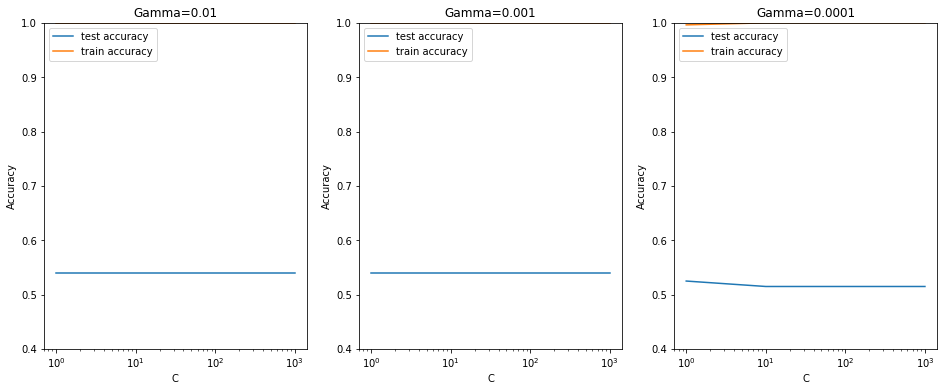

In [30]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.40, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.4, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.4, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [31]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.54 corresponding to hyperparameters {'C': 1, 'gamma': 0.01}


In [129]:
final = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='poly', max_iter=50,
                                                            C=1000,
                                                            gamma = 0.1, class_weight='balanced'
                                                           ))])
final.fit(t_features,t_labels)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=50, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])





### Binary Base Model Evaluation

In [130]:
b_test_feature, b_test_labels = FeatureExtraction(b_test_X, b_test_set)

On image 0


In [137]:
binary_y_pred = pipe.predict(b_test_feature)
#binary_y_pred = final.predict(b_test_feature)

NameError: name 'pipe' is not defined

In [132]:
Counter(binary_y_pred)

Counter({1: 96, 0: 4})

In [133]:
binary_score_test = metrics.accuracy_score(b_test_labels, binary_y_pred)
print('Base Model Test Score ',binary_score_test)

Base Model Test Score  0.51


In [134]:
binary_cm = confusion_matrix(b_test_labels, binary_y_pred)
print(binary_cm)

[[ 2 47]
 [ 2 49]]


In [135]:
binary_report = classification_report(b_test_labels,binary_y_pred)
print(binary_report)

             precision    recall  f1-score   support

          0       0.50      0.04      0.08        49
          1       0.51      0.96      0.67        51

avg / total       0.51      0.51      0.38       100



In [136]:
roc_auc_score(b_test_labels, binary_y_pred)

0.5008003201280512

## Multi-Class Base Classification Models

In [42]:
# m_train_X = random.sample(m_train_X, 200)
# m_train_set = {image: m_train_set[image] for image in m_train_X }

In [43]:
#scaler = sklearn.preprocessing.StandardScaler()

In [44]:
m_features, m_labels = FeatureExtraction(m_train_X, m_train_set)

On image 0
On image 100
On image 200
On image 300
On image 400
On image 500
On image 600
On image 700
On image 800
On image 900
On image 1000
On image 1100
On image 1200
On image 1300
On image 1400
On image 1500
On image 1600
On image 1700
On image 1800
On image 1900
On image 2000
On image 2100
On image 2200
On image 2300
On image 2400
On image 2500
On image 2600
On image 2700
On image 2800
On image 2900
On image 3000
On image 3100
On image 3200
On image 3300
On image 3400
On image 3500
On image 3600
On image 3700
On image 3800
On image 3900
On image 4000
On image 4100
On image 4200


## Multi-Class ResNet SVM Model

In [45]:
m_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', max_iter=1000, C=100, gamma=0.001, class_weight='balanced'))])
m_pipe.fit(m_features,m_labels)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [46]:
m_pipe.score(m_features,m_labels)

0.87461337140138

### Hyperparameter training

In [47]:
# # creating a KFold object with 5 splits 
# folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# # specify range of hyperparameters
# # Set the parameters by cross-validation
# hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]}]


# # specify model
# sc = StandardScaler()
# m_data = sc.fit_transform(m_features)
# m_svc = SVC(kernel='rbf')

# # set up GridSearchCV()
# m_model_cv = GridSearchCV(estimator = m_svc, 
#                         param_grid = hyper_params, 
#                         scoring= 'accuracy', 
#                         cv = folds, 
#                         verbose = 1,
#                         return_train_score=True)      

# # fit the model
# m_model_cv.fit(m_data,m_labels)

In [48]:
# m_cv_results = pd.DataFrame(m_model_cv.cv_results_)

In [49]:
# m_cv_results.head()

In [50]:
# # converting C to numeric type for plotting on x-axis
# m_cv_results['param_C'] = m_cv_results['param_C'].astype('int')

# # # plotting
# plt.figure(figsize=(16,6))

# # subplot 1/3
# plt.subplot(131)
# gamma_01 = m_cv_results[m_cv_results['param_gamma']==0.01]

# plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
# plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
# plt.xlabel('C')
# plt.ylabel('Accuracy')
# plt.title("Gamma=0.01")
# plt.ylim([0.40, 1])
# plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
# plt.xscale('log')

# # subplot 2/3
# plt.subplot(132)
# gamma_001 = m_cv_results[m_cv_results['param_gamma']==0.001]

# plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
# plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
# plt.xlabel('C')
# plt.ylabel('Accuracy')
# plt.title("Gamma=0.001")
# plt.ylim([0.4, 1])
# plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
# plt.xscale('log')


# # subplot 3/3
# plt.subplot(133)
# gamma_0001 = m_cv_results[m_cv_results['param_gamma']==0.0001]

# plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
# plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
# plt.xlabel('C')
# plt.ylabel('Accuracy')
# plt.title("Gamma=0.0001")
# plt.ylim([0.4, 1])
# plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
# plt.xscale('log')


In [51]:
# # printing the optimal accuracy score and hyperparameters
# m_best_score = m_model_cv.best_score_
# m_best_hyperparams = m_model_cv.best_params_

# print("The best test score is {0} corresponding to hyperparameters {1}".format(m_best_score, m_best_hyperparams))

In [52]:
# m_final = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', max_iter=50,
#                                                             C=m_best_hyperparams['C'],
#                                                             gamma = m_best_hyperparams['gamma']
#                                                            ))])
# m_final.fit(m_features,m_labels)

### Multi-Class Res Model Evaluation

In [53]:
# m_test_X = random.sample(m_test_X, 100)
# m_test_set = {image: m_test_set[image] for image in m_test_X }

In [54]:
m_test_feature, m_test_labels = FeatureExtraction(m_test_X, m_test_set)

On image 0
On image 100
On image 200
On image 300
On image 400
On image 500
On image 600
On image 700
On image 800
On image 900
On image 1000
On image 1100
On image 1200
On image 1300
On image 1400
On image 1500
On image 1600
On image 1700


In [56]:
multi_y_pred = m_pipe.predict(m_test_feature)

In [57]:
Counter(multi_y_pred)

Counter({0: 1583, 2: 90, 1: 124})

In [58]:
multi_score_test = metrics.accuracy_score(m_test_labels, multi_y_pred)
print('Base Model Test Score ',multi_score_test)

Base Model Test Score  0.39621591541457984


In [59]:
multi_cm = confusion_matrix(m_test_labels, multi_y_pred)
print(multi_cm)

[[554  24  21]
 [500  94   5]
 [529   6  64]]


In [60]:
multi_report = classification_report(m_test_labels,multi_y_pred)
print(multi_report)

             precision    recall  f1-score   support

          0       0.35      0.92      0.51       599
          1       0.76      0.16      0.26       599
          2       0.71      0.11      0.19       599

avg / total       0.61      0.40      0.32      1797



In [ ]:
pkl_filename = "vgg_svm_binary.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(m_pipe, file)

In [ ]:
pkl_filename = "vgg_svm_multi.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(m_pipe, file)

In [ ]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
Ypredict = pickle_model.predict(m_test_feature)

In [ ]:
multi_score_test = metrics.accuracy_score(m_test_labels, Ypredict)
print('Base Model Test Score ',multi_score_test)